# CCG Development

Notebook to compare CCG times to run in python vs. CCGheart.c mex MATLAB file from buzcode repo and develop a faster CCG in python if the python version runs much slower

First, import data to compare (neuron 20 vs 45 for 'RoyMaze1' session from Hiro dataset).

In [31]:
from scipy.io import loadmat

filepath = '/data/Working/Other Peoples Data/HiroData/wake_new/wake-spikes.mat'
session = 'RoyMaze1'

mat_in = loadmat(filepath, squeeze_me=True, struct_as_record=False)

Organize data

In [53]:
neurons = [19, 44]
spikes_use = [mat_in['spikes'].RoyMaze1[neuron] for neuron in neurons]

In [54]:
spikes_use[0].time.shape

(517090,)

Import CCG from matlab and organize data nicely

In [65]:
import ccg
import numpy as np

time_to_sec = 1/(1000*1000)  # Hiro data times are in microseconds
spikes_unsorted = np.concatenate([a.time for a in spikes_use])*time_to_sec  # assemble spikes
clu_id = np.concatenate([[idc] * len(a.time) for idc, a in enumerate(spikes_use)])  # assemble cluster ids
sort_ind = np.argsort(spikes_unsorted)
spikes = spikes_unsorted[sort_ind]
clu_id = clu_id[sort_ind]

Now run CCG!

In [75]:
window_size, bin_size = 0.007, 1/30000
ccgs = ccg.correlograms(spikes, clu_id, window_size=window_size, bin_size=bin_size, sample_rate=30000)

Now plot it!

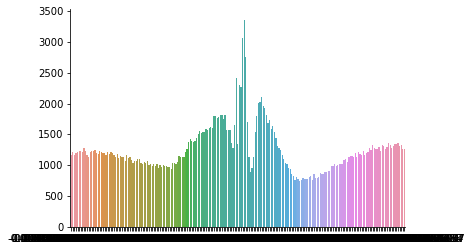

In [85]:
import seaborn as sns
# sns.barplot(y=ccgs[1,0,:])
bins = np.linspace(-window_size/2, window_size/2, num=int(0.007/bin_size + 1))
sns.barplot(x=bins, y=ccgs[1,0,:])
sns.despine()

Ok, that looks like it works (fix color issues later).  Now time the ccg run!

In [86]:
%timeit ccg.correlograms(spikes, clu_id, window_size=window_size, bin_size=bin_size, sample_rate=30000)

129 ms ± 497 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


This is a bit slower than the CCGheart function in MATLAB, which appears to run at aroun 80ms per CCG. So I need to do some Cythoning below to touch things up!

First, start by simply copying over the CCG function and compiling in Cython here...

In [88]:
%load_ext Cython

In [93]:
%%cython

import numpy as np


# ------------------------------------------------------------------------------
# Cross-correlograms
# ------------------------------------------------------------------------------
_ACCEPTED_ARRAY_DTYPES = (
    np.float,
    np.float32,
    np.float64,
    np.int,
    np.int8,
    np.int16,
    np.uint8,
    np.uint16,
    np.int32,
    np.int64,
    np.uint32,
    np.uint64,
    np.bool,
)


def _as_array(arr, dtype=None):
    """Convert an object to a numerical NumPy array.
    Avoid a copy if possible.
    """
    if arr is None:
        return None
    if isinstance(arr, np.ndarray) and dtype is None:
        return arr
    if isinstance(arr, (int, float)):
        arr = [arr]
    out = np.asarray(arr)
    if dtype is not None:
        if out.dtype != dtype:
            out = out.astype(dtype)
    if out.dtype not in _ACCEPTED_ARRAY_DTYPES:
        raise ValueError(
            "'arr' seems to have an invalid dtype: " "{0:s}".format(str(out.dtype))
        )
    return out


def _index_of(arr, lookup):
    """Replace scalars in an array by their indices in a lookup table.
    Implicitely assume that:
    * All elements of arr and lookup are non-negative integers.
    * All elements or arr belong to lookup.
    This is not checked for performance reasons.
    """
    # Equivalent of np.digitize(arr, lookup) - 1, but much faster.
    # TODO: assertions to disable in production for performance reasons.
    # TODO: np.searchsorted(lookup, arr) is faster on small arrays with large
    # values
    lookup = np.asarray(lookup, dtype=np.int32)
    m = (lookup.max() if len(lookup) else 0) + 1
    tmp = np.zeros(m + 1, dtype=np.int)
    # Ensure that -1 values are kept.
    tmp[-1] = -1
    if len(lookup):
        tmp[lookup] = np.arange(len(lookup))
    return tmp[arr]


def _unique(x):
    """Faster version of np.unique().
    This version is restricted to 1D arrays of non-negative integers.
    It is only faster if len(x) >> len(unique(x)).
    """
    if x is None or len(x) == 0:
        return np.array([], dtype=np.int64)
    # WARNING: only keep positive values.
    # cluster=-1 means "unclustered".
    x = _as_array(x)
    x = x[x >= 0]
    bc = np.bincount(x)
    return np.nonzero(bc)[0]


def _increment(arr, indices):
    """Increment some indices in a 1D vector of non-negative integers.
    Repeated indices are taken into account."""
    arr = _as_array(arr)
    indices = _as_array(indices)
    bbins = np.bincount(indices)
    arr[: len(bbins)] += bbins
    return arr


def _diff_shifted(arr, steps=1):
    arr = _as_array(arr)
    return arr[steps:] - arr[: len(arr) - steps]


def _create_correlograms_array(n_clusters, winsize_bins):
    return np.zeros((n_clusters, n_clusters, winsize_bins // 2 + 1), dtype=np.int32)


def _symmetrize_correlograms(correlograms):
    """Return the symmetrized version of the CCG arrays."""

    n_clusters, _, n_bins = correlograms.shape
    assert n_clusters == _

    # We symmetrize c[i, j, 0].
    # This is necessary because the algorithm in correlograms()
    # is sensitive to the order of identical spikes.
    correlograms[..., 0] = np.maximum(correlograms[..., 0], correlograms[..., 0].T)

    sym = correlograms[..., 1:][..., ::-1]
    sym = np.transpose(sym, (1, 0, 2))

    return np.dstack((sym, correlograms))


def firing_rate(spike_clusters, cluster_ids=None, bin_size=None, duration=None):
    """Compute the average number of spikes per cluster per bin."""

    # Take the cluster order into account.
    if cluster_ids is None:
        cluster_ids = _unique(spike_clusters)
    else:
        cluster_ids = _as_array(cluster_ids)

    # Like spike_clusters, but with 0..n_clusters-1 indices.
    spike_clusters_i = _index_of(spike_clusters, cluster_ids)

    assert bin_size > 0
    bc = np.bincount(spike_clusters_i)
    # Handle the case where the last cluster(s) are empty.
    if len(bc) < len(cluster_ids):
        n = len(cluster_ids) - len(bc)
        bc = np.concatenate((bc, np.zeros(n, dtype=bc.dtype)))
    assert bc.shape == (len(cluster_ids),)
    return bc * np.c_[bc] * (bin_size / (duration or 1.0))


def correlograms_py(
    spike_times,
    spike_clusters,
    cluster_ids=None,
    sample_rate=1.0,
    bin_size=None,
    window_size=None,
    symmetrize=True,
):
    """Compute all pairwise cross-correlograms among the clusters appearing
    in `spike_clusters`.
    Parameters
    ----------
    spike_times : array-like
        Spike times in seconds.
    spike_clusters : array-like
        Spike-cluster mapping.
    cluster_ids : array-like
        The list of *all* unique clusters, in any order. That order will be used
        in the output array.
    bin_size : float
        Size of the bin, in seconds.
    window_size : float
        Size of the window, in seconds.
    sample_rate : float
        Sampling rate.
    symmetrize : boolean (True)
        Whether the output matrix should be symmetrized or not.
    Returns
    -------
    correlograms : array
        A `(n_clusters, n_clusters, winsize_samples)` array with all pairwise CCGs.
    """
    assert sample_rate > 0.0
    assert np.all(np.diff(spike_times) >= 0), "The spike times must be " "increasing."

    # Get the spike samples.
    spike_times = np.asarray(spike_times, dtype=np.float64)
    spike_samples = (spike_times * sample_rate).astype(np.int64)

    spike_clusters = _as_array(spike_clusters)

    assert spike_samples.ndim == 1
    assert spike_samples.shape == spike_clusters.shape

    # Find `binsize`.
    bin_size = np.clip(bin_size, 1e-5, 1e5)  # in seconds
    binsize = int(sample_rate * bin_size)  # in samples
    assert binsize >= 1

    # Find `winsize_bins`.
    window_size = np.clip(window_size, 1e-5, 1e5)  # in seconds
    winsize_bins = 2 * int(0.5 * window_size / bin_size) + 1

    assert winsize_bins >= 1
    assert winsize_bins % 2 == 1

    # Take the cluster order into account.
    if cluster_ids is None:
        clusters = _unique(spike_clusters)
    else:
        clusters = _as_array(cluster_ids)
    n_clusters = len(clusters)

    # Like spike_clusters, but with 0..n_clusters-1 indices.
    spike_clusters_i = _index_of(spike_clusters, clusters)

    # Shift between the two copies of the spike trains.
    shift = 1

    # At a given shift, the mask precises which spikes have matching spikes
    # within the correlogram time window.
    mask = np.ones_like(spike_samples, dtype=np.bool)

    correlograms = _create_correlograms_array(n_clusters, winsize_bins)

    # The loop continues as long as there is at least one spike with
    # a matching spike.
    while mask[:-shift].any():
        # Number of time samples between spike i and spike i+shift.
        spike_diff = _diff_shifted(spike_samples, shift)

        # Binarize the delays between spike i and spike i+shift.
        spike_diff_b = spike_diff // binsize

        # Spikes with no matching spikes are masked.
        mask[:-shift][spike_diff_b > (winsize_bins // 2)] = False

        # Cache the masked spike delays.
        m = mask[:-shift].copy()
        d = spike_diff_b[m]

        # # Update the masks given the clusters to update.
        # m0 = np.in1d(spike_clusters[:-shift], clusters)
        # m = m & m0
        # d = spike_diff_b[m]
        d = spike_diff_b[m]

        # Find the indices in the raveled correlograms array that need
        # to be incremented, taking into account the spike clusters.
        indices = np.ravel_multi_index(
            (spike_clusters_i[:-shift][m], spike_clusters_i[+shift:][m], d),
            correlograms.shape,
        )

        # Increment the matching spikes in the correlograms array.
        _increment(correlograms.ravel(), indices)

        shift += 1

    if symmetrize:
        return _symmetrize_correlograms(correlograms)
    else:
        return correlograms

Wow, that seemed to work. Now let's time it again!

In [94]:
%timeit correlograms_py(spikes, clu_id, window_size=window_size, bin_size=bin_size, sample_rate=30000) 

132 ms ± 176 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Ok, same result as before. Need to get fancier. Next try saving this as it's own file and complining outside this notebook. Maybe that will do better?

In [96]:
import ccg_py  # this is the name of the file I compiled using `python setup.py build_ext --inplace`

%timeit ccg_py.correlograms(spikes, clu_id, window_size=window_size, bin_size=bin_size, sample_rate=30000) 

133 ms ± 372 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


If not, move onto some of the first steps in the "Cython for NumPy users" tutorial: setting types and indexing with memoryviews.

Start with setting types - do this on a function by function basis to debug and then combine at the end!  
  
IMPORTANT NOTE: Have to remove `_` before each function to test as that makes it a protected function that is inaccessible outside of the class. Remember to add those back in in the end!

Here is the `_as_array` function

In [186]:
%%cython
# cython: infer_types=True
cimport numpy as npc
import numpy as np
cimport cython


# ------------------------------------------------------------------------------
# Cross-correlograms
# ------------------------------------------------------------------------------
_ACCEPTED_ARRAY_DTYPES = (
    np.float,
    np.float32,
    np.float64,
    np.int,
    np.int8,
    np.int16,
    np.uint8,
    np.uint16,
    np.int32,
    np.int64,
    np.uint32,
    np.uint64,
    np.bool,
)

ctypedef fused my_type:
    float
    int
    unsigned int
    bint
    list
    npc.ndarray

# NRK potential slowdonwn below with dtype unset.
def as_array_cy(my_type arr, dtype=None):
    """Convert an object to a numerical NumPy array.
    Avoid a copy if possible.
    """
    cdef list arr_temp = []
    if arr is None:
        return None
    if isinstance(arr, np.ndarray) and dtype is None:
        return arr
    if isinstance(arr, (int, float)):
        arr_temp = [arr]
    out = np.asarray(arr_temp)
    if dtype is not None:
        if out.dtype != dtype:
            out = out.astype(dtype)
    if out.dtype not in _ACCEPTED_ARRAY_DTYPES:
        raise ValueError(
            "'arr' seems to have an invalid dtype: " "{0:s}".format(str(out.dtype))
        )
    return out

In [119]:
as_array_cy(1)

array([1])

Now compile pure python version and compare to make sure I'm not making things longer by accident

In [212]:
import numpy as np


# ------------------------------------------------------------------------------
# Cross-correlograms
# ------------------------------------------------------------------------------
_ACCEPTED_ARRAY_DTYPES = (
    np.float,
    np.float32,
    np.float64,
    np.int,
    np.int8,
    np.int16,
    np.uint8,
    np.uint16,
    np.int32,
    np.int64,
    np.uint32,
    np.uint64,
    np.bool,
)

def as_array_py(arr, dtype=None):
    """Convert an object to a numerical NumPy array.
    Avoid a copy if possible.
    """
    if arr is None:
        return None
    if isinstance(arr, np.ndarray) and dtype is None:
        return arr
    if isinstance(arr, (int, float)):
        arr = [arr]
    out = np.asarray(arr)
    if dtype is not None:
        if out.dtype != dtype:
            out = out.astype(dtype)
    if out.dtype not in _ACCEPTED_ARRAY_DTYPES:
        raise ValueError(
            "'arr' seems to have an invalid dtype: " "{0:s}".format(str(out.dtype))
        )
    return out

In [214]:
%timeit as_array_py([1,2,3,4,5])

1.7 µs ± 6.41 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [215]:
%timeit as_array_cy([1,2,3,4,5])

2.11 µs ± 7.62 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


ok, so it doesn't really speed it up but it's so fast anyway it doesn't matter!

That worked - onto `_index_of`

In [149]:
%%cython
# cython: infer_types=True
import numpy as np
cimport numpy as npc
cimport cython

ctypedef fused my_type:
    float
    int
    unsigned int
    bint
    list
    npc.ndarray

def index_of(my_type arr, my_type lookup):
    """Replace scalars in an array by their indices in a lookup table.
    Implicitely assume that:
    * All elements of arr and lookup are non-negative integers.
    * All elements or arr belong to lookup.
    This is not checked for performance reasons.
    """
    # Equivalent of np.digitize(arr, lookup) - 1, but much faster.
    # TODO: assertions to disable in production for performance reasons.
    # TODO: np.searchsorted(lookup, arr) is faster on small arrays with large
    # values
    cdef npc.ndarray tmp
    cdef int m
    lookup_array = np.asarray(lookup, dtype=np.int32)
    m = (lookup_array.max() if len(lookup_array) else 0) + 1
    tmp = np.zeros(m + 1, dtype=np.int)
    # Ensure that -1 values are kept.
    tmp[-1] = -1
    if len(lookup):
        tmp[lookup] = np.arange(len(lookup))
    return tmp[arr]

In [150]:
index_of([2], [1, 2, 3])

array([1])

Now compare to pure python

In [216]:
import numpy as np

def index_of_py(arr, lookup):
    """Replace scalars in an array by their indices in a lookup table.
    Implicitely assume that:
    * All elements of arr and lookup are non-negative integers.
    * All elements or arr belong to lookup.
    This is not checked for performance reasons.
    """
    # Equivalent of np.digitize(arr, lookup) - 1, but much faster.
    # TODO: assertions to disable in production for performance reasons.
    # TODO: np.searchsorted(lookup, arr) is faster on small arrays with large
    # values
    lookup = np.asarray(lookup, dtype=np.int32)
    m = (lookup.max() if len(lookup) else 0) + 1
    tmp = np.zeros(m + 1, dtype=np.int)
    # Ensure that -1 values are kept.
    tmp[-1] = -1
    if len(lookup):
        tmp[lookup] = np.arange(len(lookup))
    return tmp[arr]

In [218]:
%timeit index_of_py([2], [1, 2, 3])

9.66 µs ± 101 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [217]:
%timeit index_of([2], [1, 2, 3])

11 µs ± 124 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


Ok, same thing for `index_of` - a bit slower with cython but again super fast so it probably doesn't matter.

Onto `_unique`

In [207]:
%%cython
# cython: infer_types=True
import numpy as np
cimport numpy as npc
cimport cython

# _ACCEPTED_ARRAY_DTYPES = (
#     np.float,
#     np.float32,
#     np.float64,
#     np.int,
#     np.int8,
#     np.int16,
#     np.uint8,
#     np.uint16,
#     np.int32,
#     np.int64,
#     np.uint32,
#     np.uint64,
#     np.bool,
# )

ctypedef fused my_type:
    float
    int
    unsigned int
    bint
    list
    npc.ndarray
    
# NRK potential slowdown below with dtype unset.
def _as_array(my_type arr):  #, dtype=None):
    """Convert an object to a numerical NumPy array.
    Avoid a copy if possible.
    """
    cdef list arr_temp = []
#     if arr is None:
#         return None
    if isinstance(arr, np.ndarray): # and dtype is None:
        return arr
    if isinstance(arr, (int, float)):
        
        arr_temp = [arr]
    out = np.asarray(arr_temp)
#     if dtype is not None:
#         if out.dtype != dtype:
#             out = out.astype(dtype)
#     if out.dtype not in _ACCEPTED_ARRAY_DTYPES:
#         raise ValueError(
#             "'arr' seems to have an invalid dtype: " "{0:s}".format(str(out.dtype))
#         )
    return out

def unique(my_type x):
    """Faster version of np.unique().
    This version is restricted to 1D arrays of non-negative integers.
    It is only faster if len(x) >> len(unique(x)).
    """
    cdef npc.ndarray bc
    if x is None or len(x) == 0:
        return np.array([], dtype=np.int64)
    # WARNING: only keep positive values.
    # cluster=-1 means "unclustered".
    x_array = _as_array(x).astype('int')  # Adjust this back to _as_array when combining at end!
    x_array = x_array[x_array >= 0]
    bc = np.bincount(x_array)
    return np.nonzero(bc)[0]

In [208]:
unique(np.asarray([1, 2, 2, 5, 4, 7, 9]))

array([1, 2, 4, 5, 7, 9])

Time the above versus np.unique out of interest!

Now compare to pure python!

In [219]:
import numpy as np


# ------------------------------------------------------------------------------
# Cross-correlograms
# ------------------------------------------------------------------------------
_ACCEPTED_ARRAY_DTYPES = (
    np.float,
    np.float32,
    np.float64,
    np.int,
    np.int8,
    np.int16,
    np.uint8,
    np.uint16,
    np.int32,
    np.int64,
    np.uint32,
    np.uint64,
    np.bool,
)

def as_array_py(arr, dtype=None):
    """Convert an object to a numerical NumPy array.
    Avoid a copy if possible.
    """
    if arr is None:
        return None
    if isinstance(arr, np.ndarray) and dtype is None:
        return arr
    if isinstance(arr, (int, float)):
        arr = [arr]
    out = np.asarray(arr)
    if dtype is not None:
        if out.dtype != dtype:
            out = out.astype(dtype)
    if out.dtype not in _ACCEPTED_ARRAY_DTYPES:
        raise ValueError(
            "'arr' seems to have an invalid dtype: " "{0:s}".format(str(out.dtype))
        )
    return out

def unique_py(x):
    """Faster version of np.unique().
    This version is restricted to 1D arrays of non-negative integers.
    It is only faster if len(x) >> len(unique(x)).
    """
    if x is None or len(x) == 0:
        return np.array([], dtype=np.int64)
    # WARNING: only keep positive values.
    # cluster=-1 means "unclustered".
    x = as_array_py(x)
    x = x[x >= 0]
    bc = np.bincount(x)
    return np.nonzero(bc)[0]

In [210]:
rand_int = np.random.randint(0, 50, size=100000)

%timeit np.unique(rand_int)

2.65 ms ± 6.77 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [211]:
%timeit unique(rand_int)

399 µs ± 325 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Ok, much faster than pure numpy (6x). Now compare to python implementation.

In [220]:
%timeit unique_py(rand_int)

244 µs ± 189 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Gah - somehow I'm slowing everything down with cython - maybe when we get to the final version it will be faster? Or maybe try the above with memoryviews?

Ok, try to do `_unique` with memoryviews...

In [248]:
%%cython
# cython: infer_types=True
import numpy as np
cimport numpy as npc
cimport cython


# _ACCEPTED_ARRAY_DTYPES = (
#     np.float,
#     np.float32,
#     np.float64,
#     np.int,
#     np.int8,
#     np.int16,
#     np.uint8,
#     np.uint16,
#     np.int32,
#     np.int64,
#     np.uint32,
#     np.uint64,
#     np.bool,
# )

ctypedef fused my_type:
    float
    int
    unsigned int
    bint
    list
    npc.ndarray
    
# NRK potential slowdown below with dtype unset.
@cython.boundscheck(False)  # Deactivate bounds checking
@cython.wraparound(False)  # Deactivate negative indexing
def _as_array_cym(my_type [:] arr):  #, dtype=None):
    """Convert an object to a numerical NumPy array.
    Avoid a copy if possible.
    """
    cdef list arr_temp = []
#     if arr is None:
#         return None
    if isinstance(arr, np.ndarray): # and dtype is None:
        return arr
    if isinstance(arr, (int, float)):
        
        arr_temp = [arr]
    out = np.asarray(arr_temp)
#     if dtype is not None:
#         if out.dtype != dtype:
#             out = out.astype(dtype)
#     if out.dtype not in _ACCEPTED_ARRAY_DTYPES:
#         raise ValueError(
#             "'arr' seems to have an invalid dtype: " "{0:s}".format(str(out.dtype))
#         )
    return out

@cython.boundscheck(False)  # Deactivate bounds checking
@cython.wraparound(False)  # Deactivate negative indexing
def unique_cym(my_type [::1] x):
    """Faster version of np.unique().
    This version is restricted to 1D arrays of non-negative integers.
    It is only faster if len(x) >> len(unique(x)).
    """
    cdef npc.ndarray [:] bc
    if x is None or len(x) == 0:
        return np.array([], dtype=np.int64)
    # WARNING: only keep positive values.
    # cluster=-1 means "unclustered".
    x_array = _as_array_cym(x).astype('int')  # Adjust this back to _as_array when combining at end!
    x_array = x_array[x_array >= 0]
    bc = np.bincount(x_array)
    return np.nonzero(bc)[0]

In [249]:
%timeit unique_cym(rand_int)

412 µs ± 1.67 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Hmm, somehow adding in all the speed-up techniques from Cython actually slow this down a bunch!!! But again, it is still 6x faster than regular numpy...

In [ ]:
"""Cross-correlograms."""

# ------------------------------------------------------------------------------
# Imports
# ------------------------------------------------------------------------------

# cython: infer_types=True
import numpy as np
cimport numpy as npc
cimport cython


# ------------------------------------------------------------------------------
# Cross-correlograms
# ------------------------------------------------------------------------------
_ACCEPTED_ARRAY_DTYPES = (
    np.float,
    np.float32,
    np.float64,
    np.int,
    np.int8,
    np.int16,
    np.uint8,
    np.uint16,
    np.int32,
    np.int64,
    np.uint32,
    np.uint64,
    np.bool,
)

ctypedef fused my_type:
    float
    int
    unsigned int
    bint
    list
    npc.ndarray

def _as_array(my_type arr, dtype=None):
    """Convert an object to a numerical NumPy array.
    Avoid a copy if possible.
    """
    cdef list arr_temp = []
    if arr is None:
        return None
    if isinstance(arr, np.ndarray) and dtype is None:
        return arr
    if isinstance(arr, (int, float)):
        arr_temp = [arr]
    out = np.asarray(arr_temp)
    if dtype is not None:
        if out.dtype != dtype:
            out = out.astype(dtype)
    if out.dtype not in _ACCEPTED_ARRAY_DTYPES:
        raise ValueError(
            "'arr' seems to have an invalid dtype: " "{0:s}".format(str(out.dtype))
        )
    return out


def _index_of(my_type arr, my_type lookup):
    """Replace scalars in an array by their indices in a lookup table.
    Implicitely assume that:
    * All elements of arr and lookup are non-negative integers.
    * All elements or arr belong to lookup.
    This is not checked for performance reasons.
    """
    # Equivalent of np.digitize(arr, lookup) - 1, but much faster.
    # TODO: assertions to disable in production for performance reasons.
    # TODO: np.searchsorted(lookup, arr) is faster on small arrays with large
    # values
    cdef npc.ndarray tmp
    cdef int m
    lookup_array = np.asarray(lookup, dtype=np.int32)
    m = (lookup_array.max() if len(lookup_array) else 0) + 1
    tmp = np.zeros(m + 1, dtype=np.int)
    # Ensure that -1 values are kept.
    tmp[-1] = -1
    if len(lookup):
        tmp[lookup] = np.arange(len(lookup))
    return tmp[arr]


def _unique(my_type x):
    """Faster version of np.unique().
    This version is restricted to 1D arrays of non-negative integers.
    It is only faster if len(x) >> len(unique(x)).
    """
    cdef npc.ndarray bc
    if x is None or len(x) == 0:
        return np.array([], dtype=np.int64)
    # WARNING: only keep positive values.
    # cluster=-1 means "unclustered".
    x_array = _as_array(x).astype('int')  # Adjust this back to _as_array when combining at end!
    x_array = x_array[x_array >= 0]
    bc = np.bincount(x_array)
    return np.nonzero(bc)[0]


def _increment(my_type arr, my_type indices):
    """Increment some indices in a 1D vector of non-negative integers.
    Repeated indices are taken into account."""
    arr_array = _as_array(arr)
    indices_array = _as_array(indices)
    bbins = np.bincount(indices_array)
    arr_array[: len(bbins)] += bbins
    return arr_array


def _diff_shifted(my_type arr, int steps=1):
    arr_array = _as_array(arr)
    return arr_array[steps:] - arr_array[: len(arr) - steps]


def _create_correlograms_array(int n_clusters, my_type winsize_bins):
    return np.zeros((n_clusters, n_clusters, winsize_bins // 2 + 1), dtype=np.int32)


def _symmetrize_correlograms(my_type correlograms):
    """Return the symmetrized version of the CCG arrays."""

    n_clusters, _, n_bins = correlograms.shape
    assert n_clusters == _

    # We symmetrize c[i, j, 0].
    # This is necessary because the algorithm in correlograms()
    # is sensitive to the order of identical spikes.
    correlograms[..., 0] = np.maximum(correlograms[..., 0], correlograms[..., 0].T)

    sym = correlograms[..., 1:][..., ::-1]
    sym = np.transpose(sym, (1, 0, 2))

    return np.dstack((sym, correlograms))


def firing_rate(spike_clusters, cluster_ids=None, bin_size=None, duration=None):
    """Compute the average number of spikes per cluster per bin."""

    # Take the cluster order into account.
    if cluster_ids is None:
        cluster_ids = _unique(spike_clusters)
    else:
        cluster_ids = _as_array(cluster_ids)

    # Like spike_clusters, but with 0..n_clusters-1 indices.
    spike_clusters_i = _index_of(spike_clusters, cluster_ids)

    assert bin_size > 0
    bc = np.bincount(spike_clusters_i)
    # Handle the case where the last cluster(s) are empty.
    if len(bc) < len(cluster_ids):
        n = len(cluster_ids) - len(bc)
        bc = np.concatenate((bc, np.zeros(n, dtype=bc.dtype)))
    assert bc.shape == (len(cluster_ids),)
    return bc * np.c_[bc] * (bin_size / (duration or 1.0))


def correlograms(
    my_type spike_times,
    my_type spike_clusters,
    cluster_ids=None,
    my_type sample_rate=30000,
    bin_size=None,
    window_size=None,
    bint symmetrize=True,
):
    """Compute all pairwise cross-correlograms among the clusters appearing
    in `spike_clusters`.
    Parameters
    ----------
    spike_times : array-like
        Spike times in seconds.
    spike_clusters : array-like
        Spike-cluster mapping.
    cluster_ids : array-like
        The list of *all* unique clusters, in any order. That order will be used
        in the output array.
    bin_size : float
        Size of the bin, in seconds.
    window_size : float
        Size of the window, in seconds.
    sample_rate : float
        Sampling rate.
    symmetrize : boolean (True)
        Whether the output matrix should be symmetrized or not.
    Returns
    -------
    correlograms : array
        A `(n_clusters, n_clusters, winsize_samples)` array with all pairwise CCGs.
    """
    assert sample_rate > 0.0
    assert np.all(np.diff(spike_times) >= 0), "The spike times must be " "increasing."

    # Get the spike samples.
    spike_times = np.asarray(spike_times, dtype=np.float64)
    spike_samples = (spike_times * sample_rate).astype(np.int64)

    spike_clusters_array = _as_array(spike_clusters)

    assert spike_samples.ndim == 1
    assert spike_samples.shape == spike_clusters_array.shape

    # Find `binsize`.
    bin_size2 = np.clip(bin_size, 1e-5, 1e5)  # in seconds
    binsize = int(sample_rate * bin_size2)  # in samples
    assert binsize >= 1

    # Find `winsize_bins`.
    window_size2 = np.clip(window_size, 1e-5, 1e5)  # in seconds
    winsize_bins = 2 * int(0.5 * window_size2 / bin_size) + 1

    assert winsize_bins >= 1
    assert winsize_bins % 2 == 1

    # Take the cluster order into account.
    if cluster_ids is None:
        clusters_use = _unique(spike_clusters_array)
    else:
        clusters_use = _as_array(cluster_ids)
    n_clusters = len(clusters_use)

    # Like spike_clusters, but with 0..n_clusters-1 indices.
    spike_clusters_i = _index_of(spike_clusters_array, clusters_use)

    # Shift between the two copies of the spike trains.
    cdef int shift = 1

    # At a given shift, the mask precises which spikes have matching spikes
    # within the correlogram time window.
    mask = np.ones_like(spike_samples, dtype=np.bool)

    correlograms = _create_correlograms_array(n_clusters, winsize_bins)

    # The loop continues as long as there is at least one spike with
    # a matching spike.
    while mask[:-shift].any():
        # Number of time samples between spike i and spike i+shift.
        spike_diff = _diff_shifted(spike_samples, shift)

        # Binarize the delays between spike i and spike i+shift.
        spike_diff_b = spike_diff // binsize

        # Spikes with no matching spikes are masked.
        mask[:-shift][spike_diff_b > (winsize_bins // 2)] = False

        # Cache the masked spike delays.
        m = mask[:-shift].copy()
        d = spike_diff_b[m]

        # # Update the masks given the clusters to update.
        # m0 = np.in1d(spike_clusters[:-shift], clusters)
        # m = m & m0
        # d = spike_diff_b[m]
        d = spike_diff_b[m]

        # Find the indices in the raveled correlograms array that need
        # to be incremented, taking into account the spike clusters.
        indices = np.ravel_multi_index(
            (spike_clusters_i[:-shift][m], spike_clusters_i[+shift:][m], d),
            correlograms.shape,
        )

        # Increment the matching spikes in the correlograms array.
        _increment(correlograms.ravel(), indices)

        shift += 1

    if symmetrize:
        return _symmetrize_correlograms(correlograms)
    else:
        return correlograms

